# Chapter 3: Target Engineering

Everyone talks about **feature engineering**, myself included. But we often forget that a machine learning model has two components (in our case, as we will work with supervised machine learning only): the **features** and the **target**. It is a **couple**, and you need to keep that in mind when choosing them. Using the best short-term trading features possible to predict Amazon's quarterly earnings will lead to very poor results. Similarly, using structural features (e.g., market regime, long-term slope) to predict the variation in the next minute is totally unrealistic.  

Keep in mind that we use **machine learning**, not **magic learning**... You need to help your model understand the complex relationships in your data. To do so, a lot of work needs to be done in the **feature engineering** phase, but **target engineering** is there to simplify the goal. It is often better to split a complex task (e.g., understanding when to enter the market) into several **sub-tasks**. These sub-tasks are still complex, of course, but less complex than the original one. For example, you could focus on detecting a chart pattern, predicting volatility, or identifying the market regime.  

One last thing before we begin this chapter: **A target is not a trading strategy.** A target is a **trading signal** (information) that we are trying to explain using features. Let me give you some examples of possible targets (this is a non-exhaustive list):  

- The **next candle color** (red or green)  
- The **volatility** of the asset  
- The **market regime**  
- The **next variation**  
- The **variation over a period of time**  

Once you have some trading signals, your goal is to combine them into an **interesting trading strategy**. For example, you could combine market regime, the variation over a period of time, and the next candle color to decide whether to enter a position or not. If all of these signals predict an increase simultaneously, the odds of being profitable in a buy position might be higher.  


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ta
import seaborn as sns
sns.set_style("whitegrid")
from Signals import *

In [3]:
# Import the dataset
df = pd.read_parquet("DATA/EURUSD_4H_dataset.parquet")
df

,open,high,low,close,tick_volume,high_time,low_time,hurst,0_to_20,20_to_40,...,ret_log_10,ret_log_20,ret_log_50,candle_way,filling,amplitude,rolling_volatility_yang_zhang,linear_slope_6M,linear_slope_3M,linear_slope_1M
time,,,,,,,,,,,,,,,,,,,,,
2014-11-14 00:00:00,1.24750,1.24789,1.24588,1.24665,14537,2014-11-14 00:12:00,2014-11-14 03:09:00,0.606340,12.446352,23.175966,...,NaN,NaN,NaN,-1,0.422886,0.068159,NaN,NaN,NaN,NaN
2014-11-14 04:00:00,1.24665,1.24669,1.24266,1.24307,17128,2014-11-14 04:00:00,2014-11-14 07:46:00,0.710822,12.552301,12.970711,...,NaN,NaN,NaN,-1,0.888337,0.287583,NaN,NaN,NaN,NaN
2014-11-14 08:00:00,1.24306,1.24711,1.24262,1.24623,35033,2014-11-14 10:34:00,2014-11-14 08:04:00,0.583402,22.500000,15.000000,...,NaN,NaN,NaN,1,0.706013,0.254691,NaN,NaN,NaN,NaN
2014-11-14 12:00:00,1.24614,1.24686,1.23982,1.24140,41784,2014-11-14 12:02:00,2014-11-14 15:36:00,0.593497,5.000000,7.500000,...,NaN,NaN,NaN,-1,0.673295,0.381099,NaN,NaN,NaN,NaN
2014-11-14 16:00:00,1.24140,1.25435,1.24054,1.25140,74087,2014-11-14 19:17:00,2014-11-14 16:05:00,0.682967,25.416667,11.250000,...,NaN,NaN,NaN,1,0.724113,0.802311,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-13 04:00:00,1.06277,1.06290,1.06092,1.06127,3868,2024-11-13 04:00:00,2024-11-13 07:22:00,0.553327,7.916667,15.000000,...,-0.052179,-0.229451,-0.295852,-1,0.757576,0.141240,0.002015,0.000021,-0.000124,-0.000117
2024-11-13 08:00:00,1.06127,1.06295,1.05931,1.06266,7587,2024-11-13 11:55:00,2024-11-13 10:09:00,0.541830,3.750000,33.333333,...,-0.033054,-0.197266,-0.279098,1,0.381868,0.130889,0.001949,0.000021,-0.000125,-0.000122
2024-11-13 12:00:00,1.06265,1.06539,1.06097,1.06362,12339,2024-11-13 15:30:00,2024-11-13 13:31:00,0.549468,31.250000,25.000000,...,-0.027691,-0.180218,-0.261703,1,0.219457,0.091240,0.002024,0.000020,-0.000126,-0.000125


<br>

### 3.1. Next candle color

This is one of the simplest targets. Generally, you never use it alone, but it can serve as a **short-term entry signal**. For example, if you aim to stay in the market for a maximum of 10 candles, predicting the color of the **next candle** or the **two next candles** can be interesting. This helps minimize the odds of entering during a **decreasing movement**.


In [3]:
def next_candle_color(df):
    df_copy = df.copy()
    
    # Compute the candle color
    df_copy["open_close_var"] = df_copy["close"] - df_copy["open"]

    df_copy["candle_color"] = np.nan
    df_copy.loc[0 < df_copy["open_close_var"], "candle_color"] = 1
    df_copy.loc[df_copy["open_close_var"] < 0, "candle_color"] = 0

    # One row shift
    df_copy["next_candle_color"] = df_copy["candle_color"].shift(-1)
    
    return df_copy

df = next_candle_color(df)

In [4]:
df

,open,high,low,close,tick_volume,high_time,low_time,hurst,0_to_20,20_to_40,...,candle_way,filling,amplitude,rolling_volatility_yang_zhang,linear_slope_6M,linear_slope_3M,linear_slope_1M,open_close_var,candle_color,next_candle_color
time,,,,,,,,,,,,,,,,,,,,,
2014-11-14 00:00:00,1.24750,1.24789,1.24588,1.24665,14537,2014-11-14 00:12:00,2014-11-14 03:09:00,0.606340,12.446352,23.175966,...,-1,0.422886,0.068159,NaN,NaN,NaN,NaN,-0.00085,0.0,0.0
2014-11-14 04:00:00,1.24665,1.24669,1.24266,1.24307,17128,2014-11-14 04:00:00,2014-11-14 07:46:00,0.710822,12.552301,12.970711,...,-1,0.888337,0.287583,NaN,NaN,NaN,NaN,-0.00358,0.0,1.0
2014-11-14 08:00:00,1.24306,1.24711,1.24262,1.24623,35033,2014-11-14 10:34:00,2014-11-14 08:04:00,0.583402,22.500000,15.000000,...,1,0.706013,0.254691,NaN,NaN,NaN,NaN,0.00317,1.0,0.0
2014-11-14 12:00:00,1.24614,1.24686,1.23982,1.24140,41784,2014-11-14 12:02:00,2014-11-14 15:36:00,0.593497,5.000000,7.500000,...,-1,0.673295,0.381099,NaN,NaN,NaN,NaN,-0.00474,0.0,1.0
2014-11-14 16:00:00,1.24140,1.25435,1.24054,1.25140,74087,2014-11-14 19:17:00,2014-11-14 16:05:00,0.682967,25.416667,11.250000,...,1,0.724113,0.802311,NaN,NaN,NaN,NaN,0.01000,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-13 04:00:00,1.06277,1.06290,1.06092,1.06127,3868,2024-11-13 04:00:00,2024-11-13 07:22:00,0.553327,7.916667,15.000000,...,-1,0.757576,0.141240,0.002015,0.000021,-0.000124,-0.000117,-0.00150,0.0,1.0
2024-11-13 08:00:00,1.06127,1.06295,1.05931,1.06266,7587,2024-11-13 11:55:00,2024-11-13 10:09:00,0.541830,3.750000,33.333333,...,1,0.381868,0.130889,0.001949,0.000021,-0.000125,-0.000122,0.00139,1.0,1.0
2024-11-13 12:00:00,1.06265,1.06539,1.06097,1.06362,12339,2024-11-13 15:30:00,2024-11-13 13:31:00,0.549468,31.250000,25.000000,...,1,0.219457,0.091240,0.002024,0.000020,-0.000126,-0.000125,0.00097,1.0,0.0


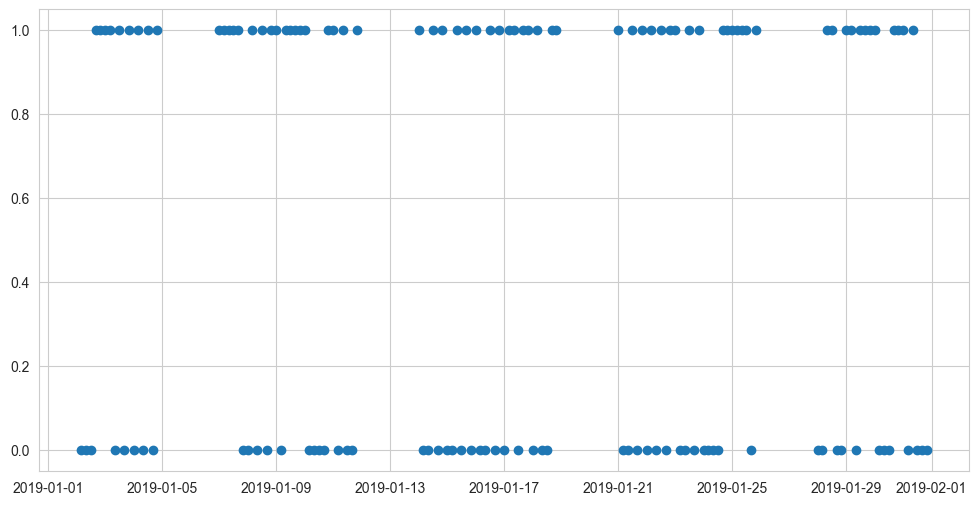

In [6]:
plt.figure(figsize=(12, 6))
plt.plot(df["next_candle_color"].loc["2019-01"], "o")
plt.show()

<br>

### 3.2 Market Regime

Here, we will use a **market regime feature** based on the **Directional Change** in the price, detailed in the `Signals.py` file.

In [9]:
df = future_DC_market_regime(df,0.10)
df

,open,high,low,close,tick_volume,high_time,low_time,hurst,0_to_20,20_to_40,...,filling,amplitude,rolling_volatility_yang_zhang,linear_slope_6M,linear_slope_3M,linear_slope_1M,open_close_var,candle_color,next_candle_color,future_market_regime
time,,,,,,,,,,,,,,,,,,,,,
2014-11-14 00:00:00,1.24750,1.24789,1.24588,1.24665,14537.0,2014-11-14 00:12:00,2014-11-14 03:09:00,0.606340,12.446352,23.175966,...,0.422886,0.068159,NaN,NaN,NaN,NaN,-0.00085,0.0,0.0,NaN
2014-11-14 04:00:00,1.24665,1.24669,1.24266,1.24307,17128.0,2014-11-14 04:00:00,2014-11-14 07:46:00,0.710822,12.552301,12.970711,...,0.888337,0.287583,NaN,NaN,NaN,NaN,-0.00358,0.0,1.0,NaN
2014-11-14 08:00:00,1.24306,1.24711,1.24262,1.24623,35033.0,2014-11-14 10:34:00,2014-11-14 08:04:00,0.583402,22.500000,15.000000,...,0.706013,0.254691,NaN,NaN,NaN,NaN,0.00317,1.0,0.0,NaN
2014-11-14 12:00:00,1.24614,1.24686,1.23982,1.24140,41784.0,2014-11-14 12:02:00,2014-11-14 15:36:00,0.593497,5.000000,7.500000,...,0.673295,0.381099,NaN,NaN,NaN,NaN,-0.00474,0.0,1.0,NaN
2014-11-14 16:00:00,1.24140,1.25435,1.24054,1.25140,74087.0,2014-11-14 19:17:00,2014-11-14 16:05:00,0.682967,25.416667,11.250000,...,0.724113,0.802311,NaN,NaN,NaN,NaN,0.01000,1.0,1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-13 04:00:00,1.06277,1.06290,1.06092,1.06127,3868.0,2024-11-13 04:00:00,2024-11-13 07:22:00,0.553327,7.916667,15.000000,...,0.757576,0.141240,0.002015,0.000021,-0.000124,-0.000117,-0.00150,0.0,1.0,1.0
2024-11-13 08:00:00,1.06127,1.06295,1.05931,1.06266,7587.0,2024-11-13 11:55:00,2024-11-13 10:09:00,0.541830,3.750000,33.333333,...,0.381868,0.130889,0.001949,0.000021,-0.000125,-0.000122,0.00139,1.0,1.0,1.0
2024-11-13 12:00:00,1.06265,1.06539,1.06097,1.06362,12339.0,2024-11-13 15:30:00,2024-11-13 13:31:00,0.549468,31.250000,25.000000,...,0.219457,0.091240,0.002024,0.000020,-0.000126,-0.000125,0.00097,1.0,0.0,1.0


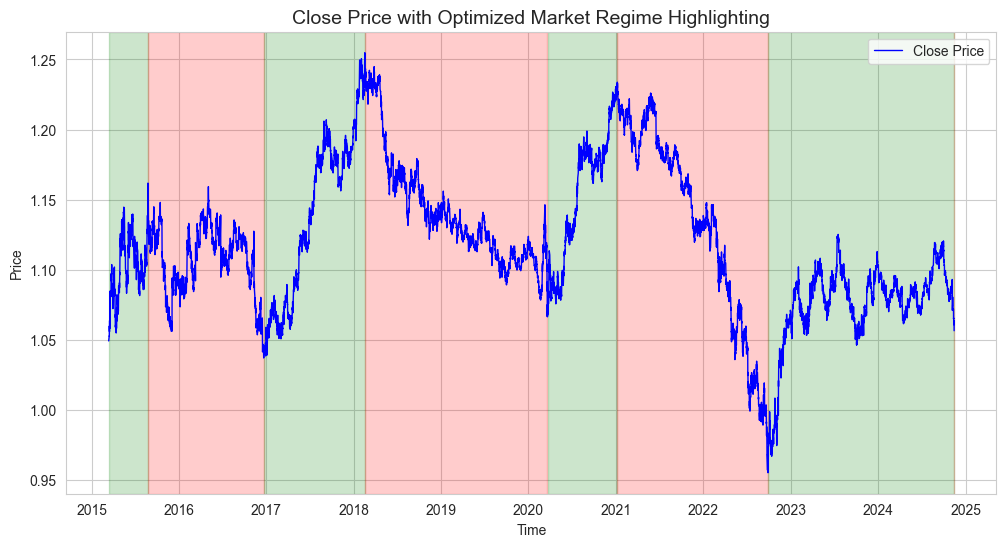

In [10]:
# Step 1: Prepare the DataFrame
dft = df[["future_market_regime", "close"]].copy().dropna()  # Keep only necessary columns and drop NaN values
dft['change'] = dft['future_market_regime'].ne(dft['future_market_regime'].shift()).cumsum()  # Identify consecutive zones
dft["time"] = dft.index  # Preserve the datetime index in a column for easier processing

# Step 2: Group consecutive zones
zones = dft.groupby('change').agg(
    start=('time', 'first'),  # Start of the zone
    end=('time', 'last'),    # End of the zone
    regime=('future_market_regime', 'first')  # Regime value (0 or 1)
).reset_index()

# Step 3: Configure the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the price line ('close' in your DataFrame)
ax.plot(dft.index, dft['close'], label='Close Price', color='blue', linewidth=1)

# Add colored zones (red or green) based on the regime
for _, row in zones.iterrows():
    if row['regime'] == 1:  # Green zone
        ax.axvspan(row['start'], row['end'], color='green', alpha=0.2)
    else:  # Red zone
        ax.axvspan(row['start'], row['end'], color='red', alpha=0.2)

# Customization
ax.set_title("Close Price with Optimized Market Regime Highlighting", fontsize=14)
ax.set_xlabel("Time")
ax.set_ylabel("Price")
ax.legend()
plt.show()

<br>

### 3.3. Barrier Labeling

This target is based on Marco Lopez de Prado's **triple barrier method**, but with a slight twist. Instead of limiting the number of candles upfront, we first calculate the exact number of candles required to hit either the Take Profit (TP) or the Stop Loss (SL). Once this is determined, we create a **dummy variable** to label the outcome.  

The feature calculates two key pieces of information:  
1. Whether the TP or SL is reached first.  
2. The number of candles it takes to reach the barrier.  

This method provides a flexible and adaptive way to label price movements, making it more robust for trading strategies that rely on risk and reward dynamics.


In [12]:
# Create the labels (that will allow us to find the interesting features that are related to them)
df["time"] = df.index
df["high_time"] = df["high_time"].apply(lambda x: x.strftime('%Y-%m-%d %H:%M:%S')).astype(str)
df["low_time"] = df["low_time"].apply(lambda x: x.strftime('%Y-%m-%d %H:%M:%S')).astype(str)
df["time"] = df["time"].apply(lambda x: x.strftime('%Y-%m-%d %H:%M:%S')).astype(str)

df = get_barrier(df, tp=.0050, sl=-.0050, buy=True)

100%|███████████████████████████████████| 15541/15541 [00:10<00:00, 1435.18it/s]

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0


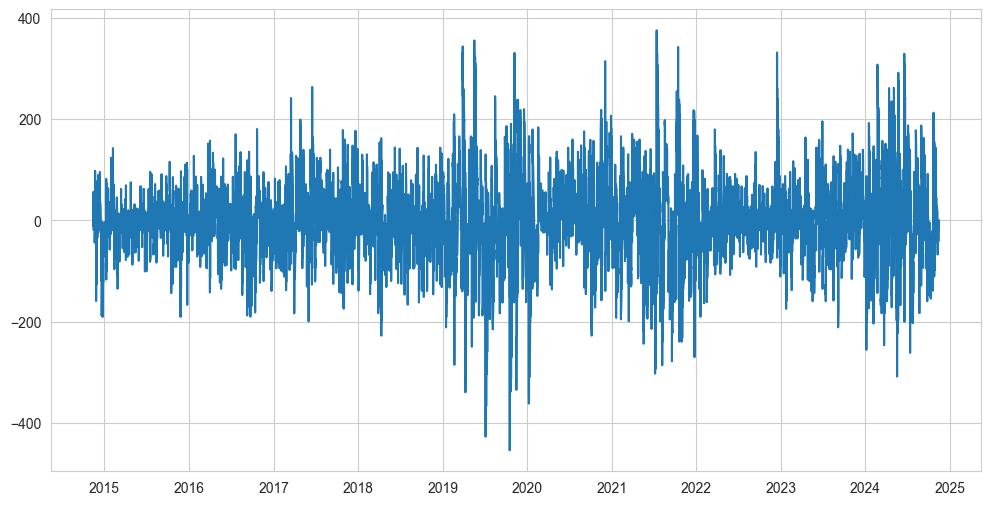

In [9]:
plt.figure(figsize=(12, 6))

plt.plot(df["labeling"])

In [10]:
def dummy_labeling(df):
    df_copy = df.copy()
    
    df_copy["dummy"] = -1
    df_copy.loc[df_copy["labeling"]<0, "dummy"] = 0
    df_copy.loc[0<df_copy["labeling"], "dummy"] = 1
    
    df_copy = df_copy[df_copy["dummy"]!=-1]
    
    return df_copy

df = dummy_labeling(df)

In [11]:
df

,open,high,low,close,tick_volume,high_time,low_time,hurst,0_to_20,20_to_40,...,linear_slope_6M,linear_slope_3M,linear_slope_1M,open_close_var,candle_color,next_candle_color,future_market_regime,time,labeling,dummy
time,,,,,,,,,,,,,,,,,,,,,
2014-11-14 00:00:00,1.24750,1.24789,1.24588,1.24665,14537.0,2014-11-14 00:12:00,2014-11-14 03:09:00,0.606340,12.446352,23.175966,...,NaN,NaN,NaN,-0.00085,0.0,0.0,NaN,2014-11-14 00:00:00,-11.600000,0
2014-11-14 04:00:00,1.24665,1.24669,1.24266,1.24307,17128.0,2014-11-14 04:00:00,2014-11-14 07:46:00,0.710822,12.552301,12.970711,...,NaN,NaN,NaN,-0.00358,0.0,1.0,NaN,2014-11-14 04:00:00,11.283333,1
2014-11-14 08:00:00,1.24306,1.24711,1.24262,1.24623,35033.0,2014-11-14 10:34:00,2014-11-14 08:04:00,0.583402,22.500000,15.000000,...,NaN,NaN,NaN,0.00317,1.0,0.0,NaN,2014-11-14 08:00:00,-3.600000,0
2014-11-14 12:00:00,1.24614,1.24686,1.23982,1.24140,41784.0,2014-11-14 12:02:00,2014-11-14 15:36:00,0.593497,5.000000,7.500000,...,NaN,NaN,NaN,-0.00474,0.0,1.0,NaN,2014-11-14 12:00:00,3.283333,1
2014-11-14 16:00:00,1.24140,1.25435,1.24054,1.25140,74087.0,2014-11-14 19:17:00,2014-11-14 16:05:00,0.682967,25.416667,11.250000,...,NaN,NaN,NaN,0.01000,1.0,1.0,NaN,2014-11-14 16:00:00,56.583333,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-12 20:00:00,1.06066,1.06263,1.06062,1.06227,6069.0,2024-11-12 23:05:00,2024-11-12 20:00:00,0.499964,6.276151,33.472803,...,0.000022,-0.000122,-0.000109,0.00161,1.0,1.0,0.0,2024-11-12 20:00:00,-17.133333,0
2024-11-13 00:00:00,1.06180,1.06288,1.06106,1.06277,4596.0,2024-11-13 03:46:00,2024-11-13 02:15:00,0.469370,16.595745,32.340426,...,0.000022,-0.000123,-0.000113,0.00097,1.0,0.0,0.0,2024-11-13 00:00:00,-13.133333,0
2024-11-13 04:00:00,1.06277,1.06290,1.06092,1.06127,3868.0,2024-11-13 04:00:00,2024-11-13 07:22:00,0.553327,7.916667,15.000000,...,0.000021,-0.000124,-0.000117,-0.00150,0.0,1.0,0.0,2024-11-13 04:00:00,-9.133333,0


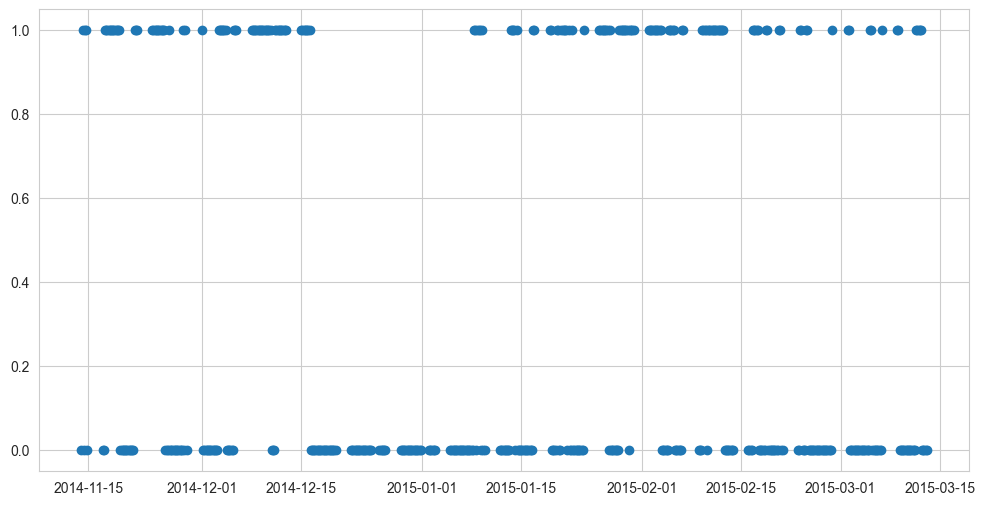

In [12]:
plt.figure(figsize=(12, 6))
plt.plot(df["dummy"].iloc[:500], "o")
plt.show()

In [13]:
# Save the data in order to use it later
del df["time"]
df.to_parquet("DATA/EURUSD_4H_dataset_signal_included.parquet", engine='fastparquet', compression="gzip")

### It is your turn !
Try to create a new Target and share it into the community!